# HMM在股票市场中的应用 #

### 牛市、熊市、震荡、反弹，想法不错，但是会不会有预测未来之嫌

我们假设隐藏状态数量是6，即假设股市的状态有6种，虽然我们并不知道每种状态到底是什么，但是通过后面的图我们可以看出那种状态下市场是上涨的，哪种是震荡的，哪种是下跌的。可观测的特征状态我们选择了3个指标进行标示，进行预测的时候假设假设所有的特征向量的状态服从高斯分布，这样就可以使用<font color=#0099ff> hmmlearn </font>这个包中的<font color=#0099ff> GaussianHMM </font>进行预测了。下面我会逐步解释。

首先导入必要的包：

In [1]:
from hmmlearn.hmm import GaussianHMM
import numpy as np
from matplotlib import cm, pyplot as plt
import matplotlib.dates as dates
import pandas as pd
import datetime

测试时间从2005年1月1日到2015年12月31日，拿到每日沪深300的各种交易数据。

In [2]:
instruments('CSI300.INDX')

Instrument(round_lot=1.0, exchange='XSHG', abbrev_symbol='HS300ZS(H)', listed_date='2002-01-04', de_listed_date='0000-00-00', symbol='沪深300', order_book_id='CSI300.INDX', type='INDX')

In [3]:
beginDate = '2010-01-01'
endDate = '2017-10-15'
n = 3 #3个隐藏状态
data = get_price('CSI300.INDX',start_date=beginDate, end_date=endDate,frequency='1d')
data.head()

,open,close,high,low,total_turnover,volume
2010-01-04,3592.468,3535.229,3597.748,3535.229,9.341984e+10,66101080.0
2010-01-05,3545.186,3564.038,3577.526,3497.661,1.283024e+11,85809641.0
2010-01-06,3558.700,3541.727,3588.832,3541.173,1.210460e+11,78473125.0
2010-01-07,3543.160,3471.456,3558.556,3452.769,1.204362e+11,80350037.0
2010-01-08,3456.908,3480.130,3482.083,3426.698,9.019096e+10,60790253.0


拿到每日成交量和收盘价的数据。

In [4]:
volume = data['volume']
close = data['close']

计算每日最高最低价格的对数差值，作为特征状态的一个指标。

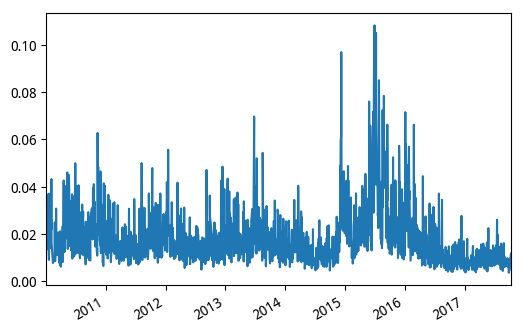

In [5]:
logDel = np.log(data['high']) - np.log(data['low'])
logDel.plot()

计算每5日的指数对数收益差，作为特征状态的一个指标。

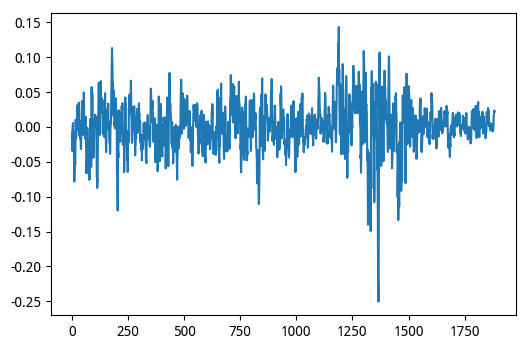

In [6]:
logRet_1 = np.array(np.diff(np.log(close)))#每日收益
logRet_5 = np.log(np.array(close[5:])/np.array(close[:-5]))
plt.plot(logRet_5)

计算每5日的指数成交量的对数差，作为特征状态的一个指标。

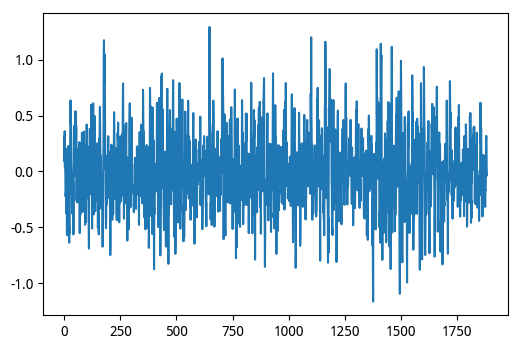

In [7]:
logVol_5 = np.log(np.array(volume[5:])/np.array(volume[:-5]))
plt.plot(logVol_5)

由于计算中出现了以5天为单位的计算，所以要调整特征指标的长度。

In [8]:
logDel = logDel[5:]
logRet_1 = logRet_1[4:]
close = close[5:]
Date = pd.to_datetime(data.index[5:])
Date[:5]

DatetimeIndex(['2010-01-11', '2010-01-12', '2010-01-13', '2010-01-14',
               '2010-01-15'],
              dtype='datetime64[ns]', freq=None)

把我们的特征状态合并在一起。

In [9]:
logDel.shape,logRet_1.shape,logVol_5.shape

((1884,), (1884,), (1884,))

In [10]:
np.array([logDel,logRet_5,logVol_5]).T.shape

(1884, 3)

In [11]:
A = np.array([logDel,logRet_5,logVol_5]).T
A.shape

(1884, 3)

下面运用<font color=#0099ff> hmmlearn </font>这个包中的<font color=#0099ff> GaussianHMM </font>进行预测。

In [12]:
model = GaussianHMM(n_components= 5, covariance_type="full", n_iter=2000).fit(A)
hidden_states = model.predict(A)
#hidden_states.shape

/opt/conda/envs/ricequant/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/envs/ricequant/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/envs/ricequant/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/envs/ricequant/lib/python3.5/s

我们把每个预测的状态用不同颜色标注在指数曲线上看一下结果。

In [13]:
model

GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=5, n_iter=2000, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

In [14]:
hidden_states

array([1, 4, 4, ..., 2, 2, 2])

In [15]:
#plt.plot_date

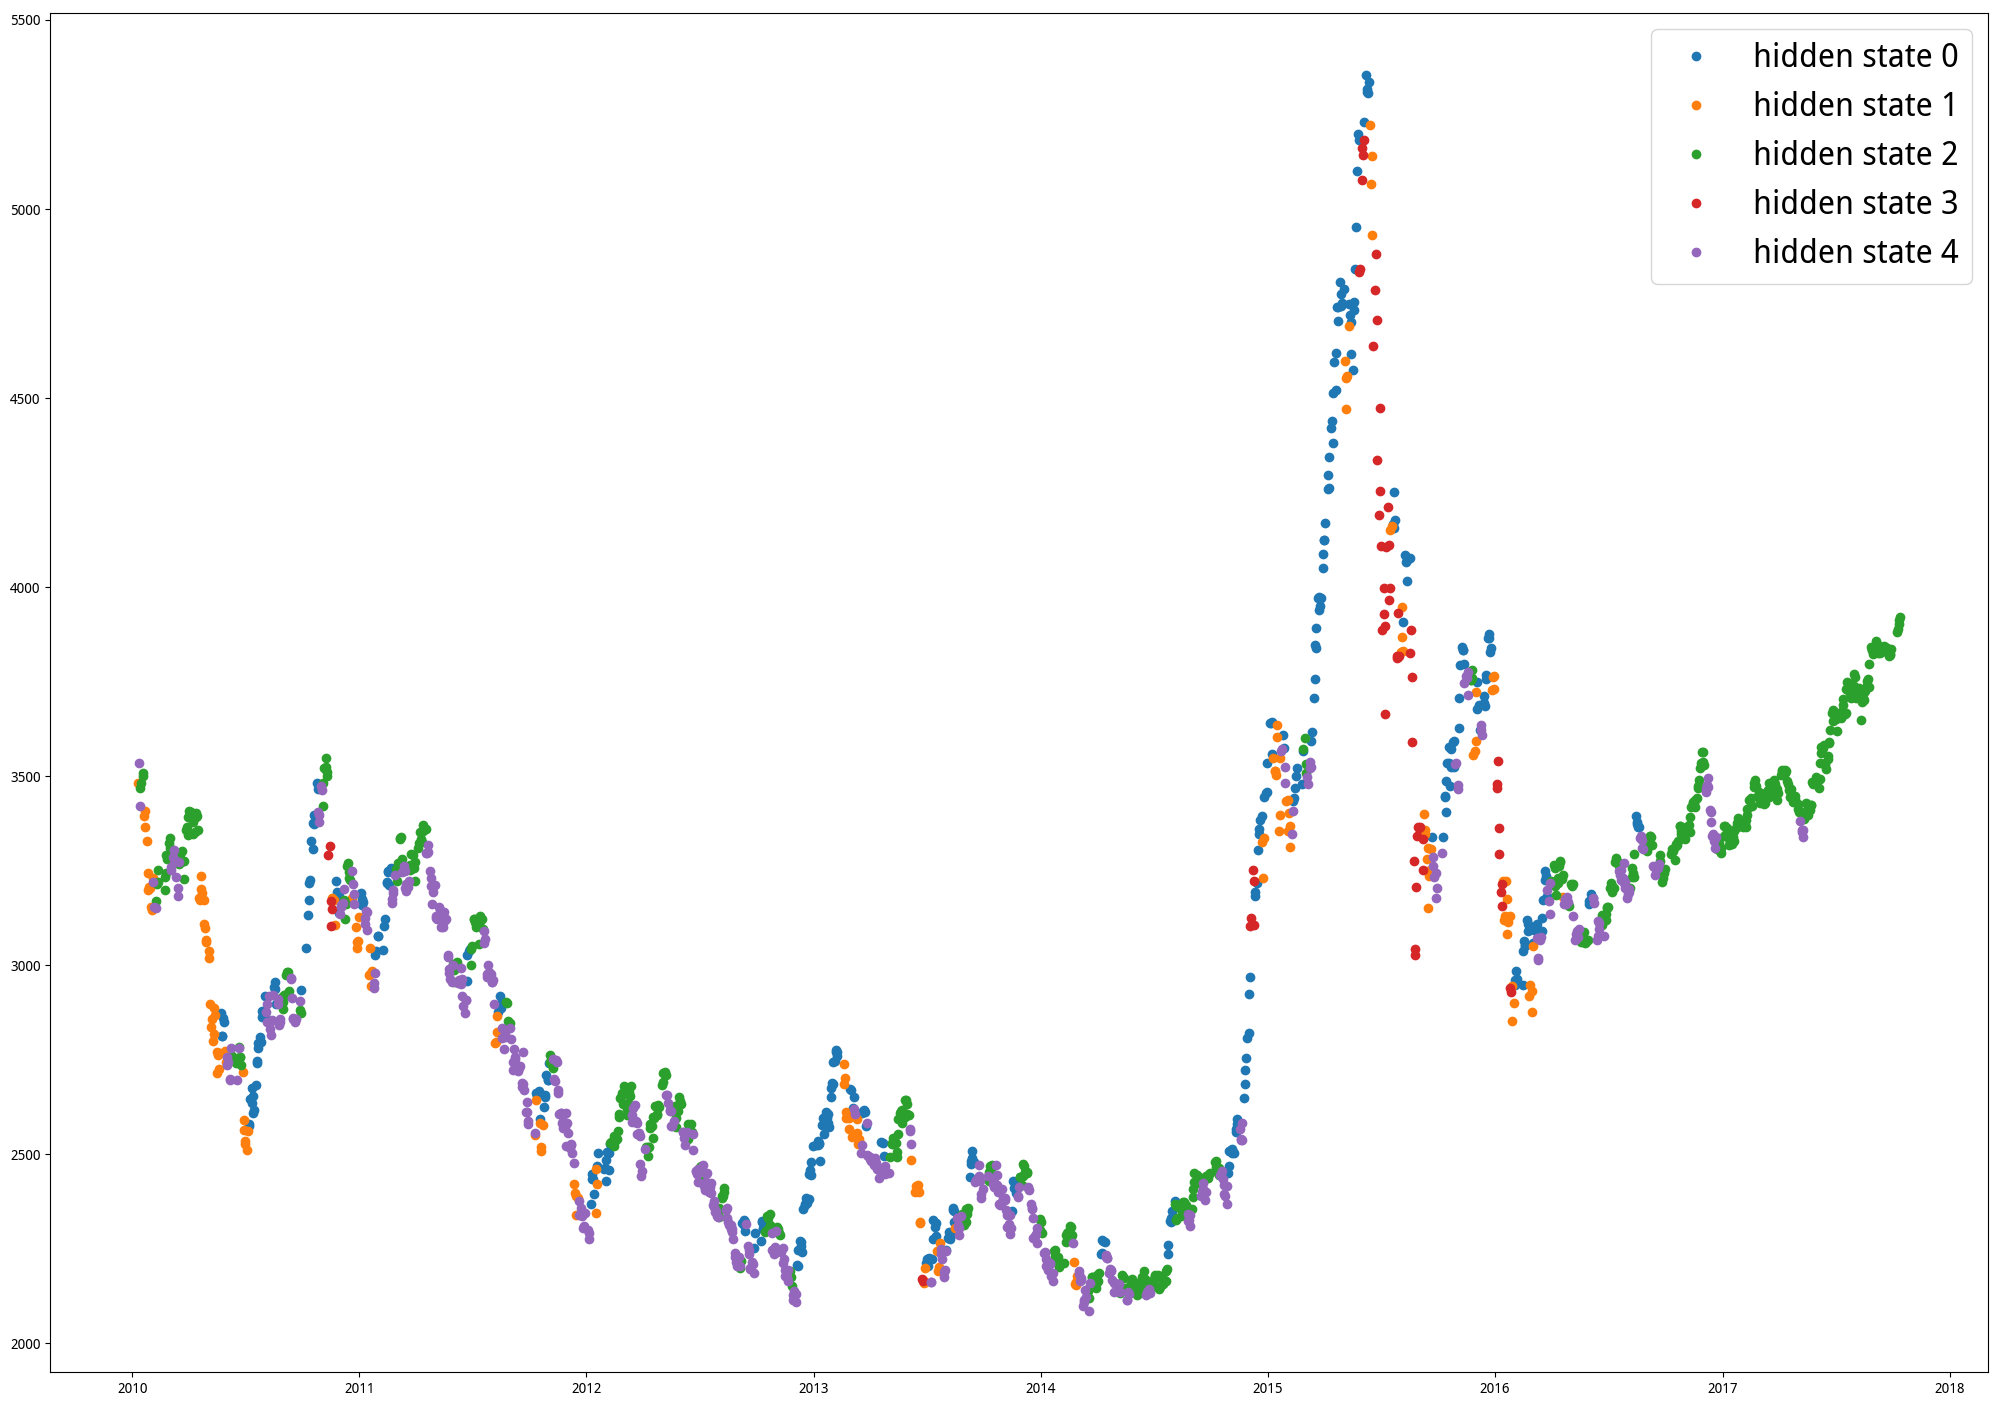

In [16]:
plt.figure(figsize=(25, 18)) 
for i in range(model.n_components):
    pos = (hidden_states==i)
    plt.plot_date(Date[pos],close[pos],'o',label='hidden state %d'%i,lw=2)
    plt.legend(loc="best",fontsize=23)

从图片中可以看到不同颜色代表不同的状态，但是这属于未来函数。不过既然那篇论文认为这个有一定效果就可以继续研究。

In [17]:
res = pd.DataFrame({'Date':Date,'logRet_1':logRet_1,'state':hidden_states}).set_index('Date')
res.head()#隔日收益

,logRet_1,state
Date,,
2010-01-11,0.000552,1
2010-01-12,0.015068,4
2010-01-13,-0.032715,4
2010-01-14,0.013906,2
2010-01-15,0.003938,2


0
1
0
0
0


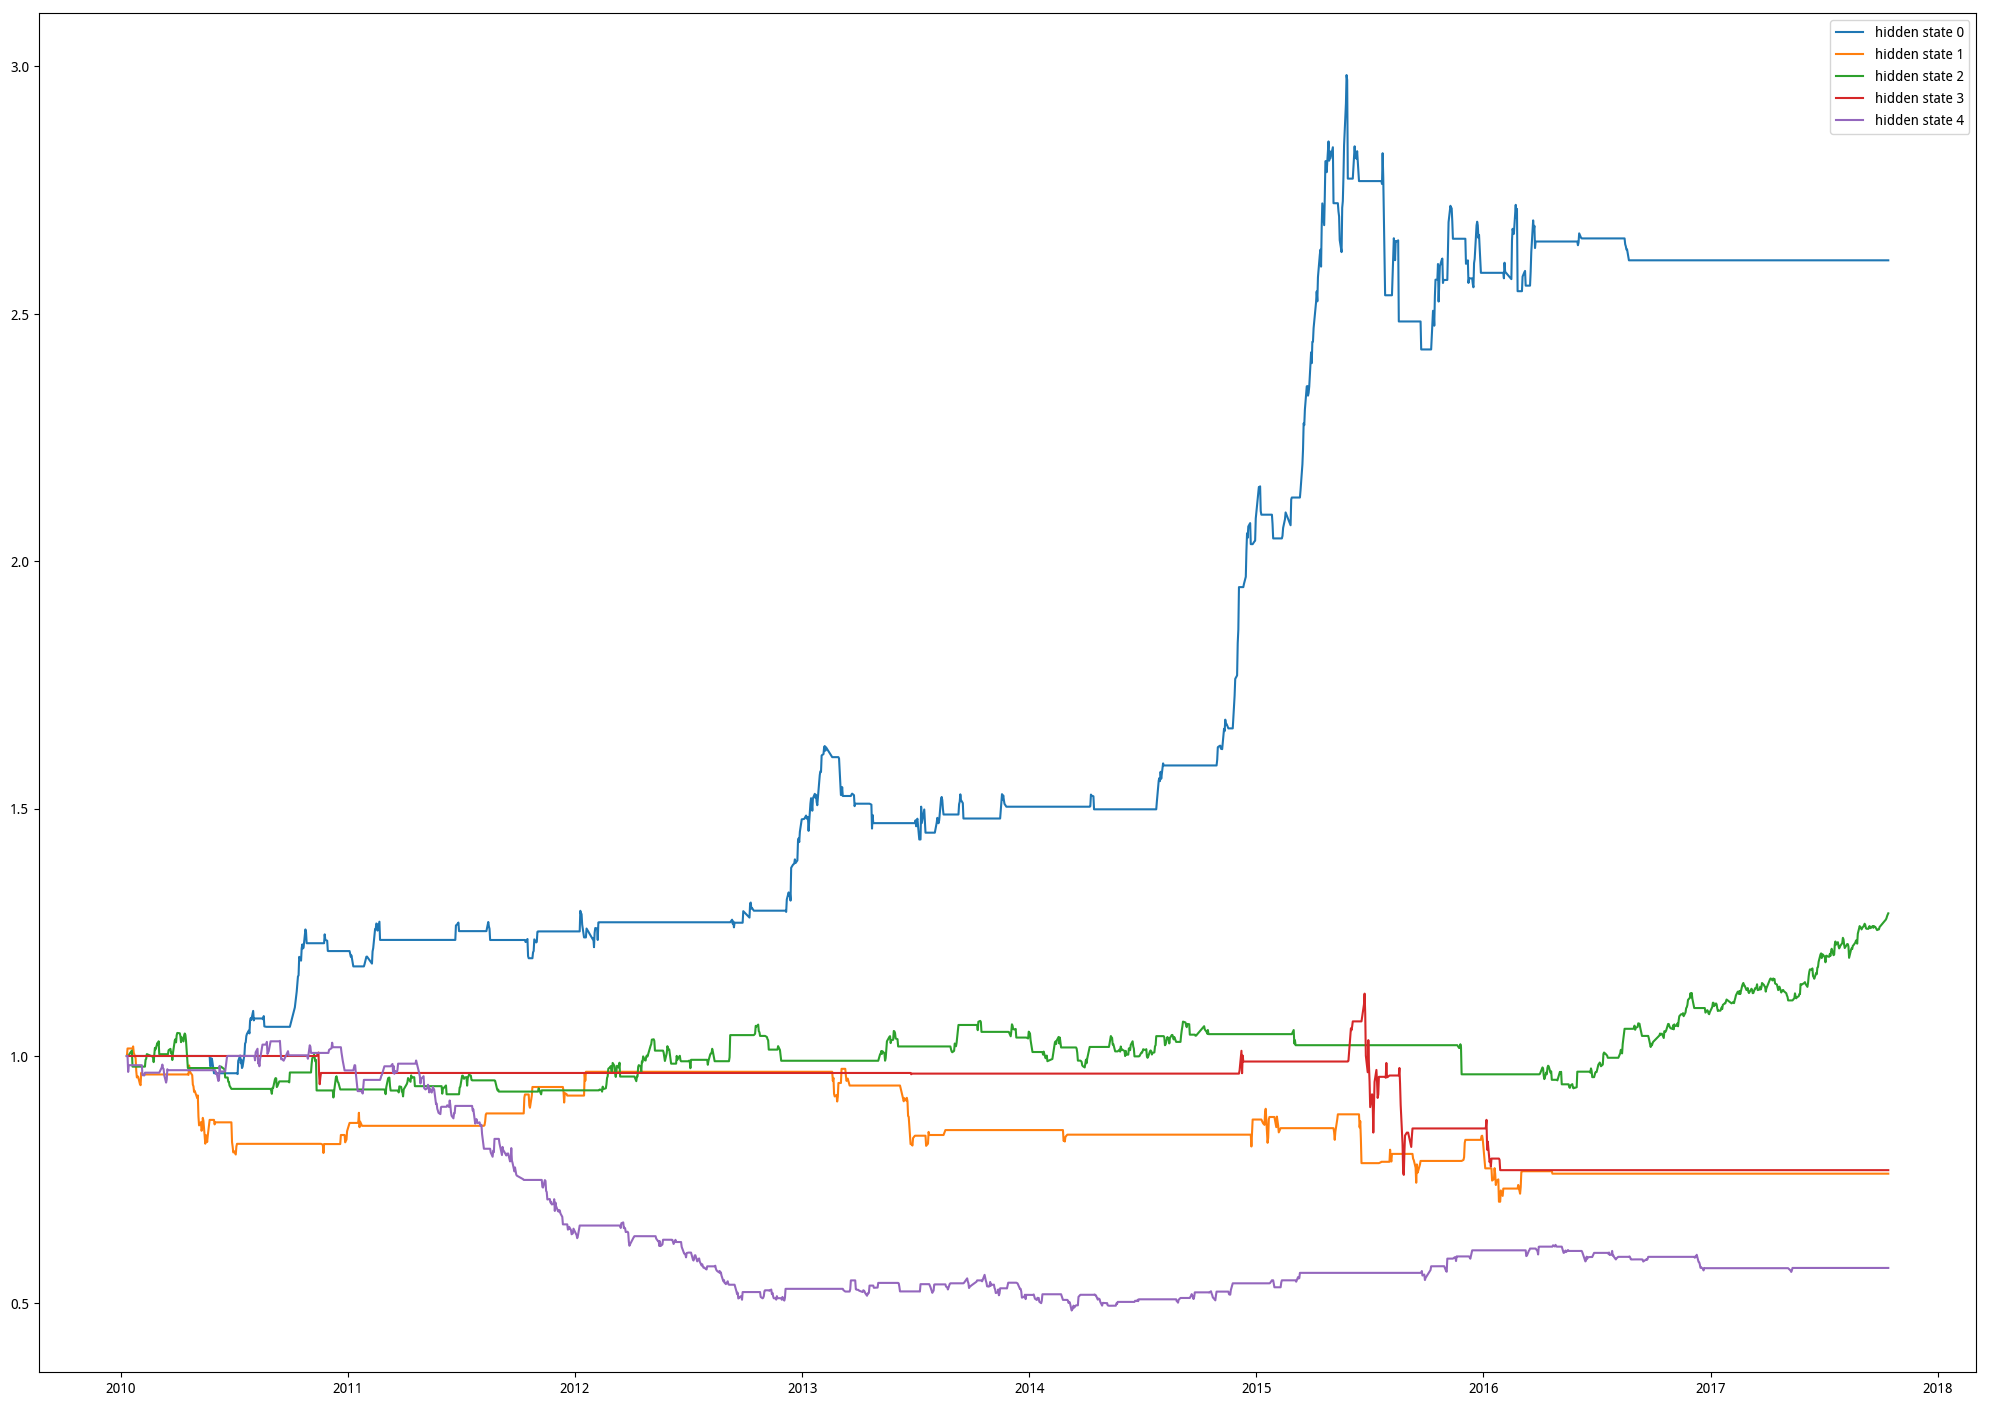

In [18]:
plt.figure(figsize=(25, 18)) 
for i in range(model.n_components):
    pos = (hidden_states==i)# 不同状态的数据，bool
    #pos.shitf().fillna(0.0)#日期向上，即是数据往后一天
    pos = np.append(0,pos[:-1])#第二天进行买入操作
    print(pos[1])
    #以后每个状态都持有。未来函数
    df = res.logRet_1#隔日收益率
    res['state_ret%s'%i] = df*np.array(pos)#对应相乘
    plt.plot_date(Date,np.exp(res['state_ret%s'%i].cumsum()),'-',label='hidden state %d'%i)
    plt.legend(loc="best")

可以看到，隐藏状态1是一个明显的大牛市阶段，隐藏状态0是一个缓慢上涨的阶段(可能对应反弹)，隐藏状态3和5可以分别对应震荡下跌的大幅下跌。其他的两个隐藏状态并不是很明确。由于股指期货可以做空，我们可以进行如下操作：当处于状态0和1时第二天做多，当处于状态3和5第二天做空，其余状态则不持有。

In [23]:
long = (hidden_states==0)  #做多
short = (hidden_states==4)  #做空
long = np.append(0,long[:-1]) #第二天才能操作
short = np.append(0,short[:-1]) #第二天才能操作


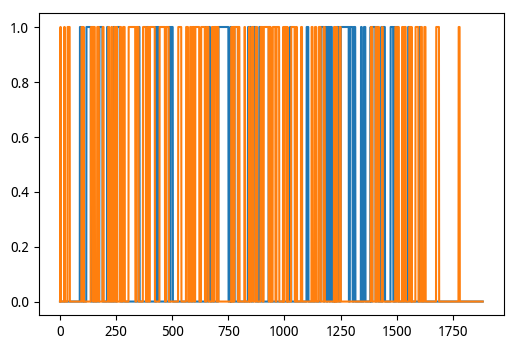

In [24]:
plt.plot(long,'-')
plt.plot(short,'-')

收益曲线图如下：

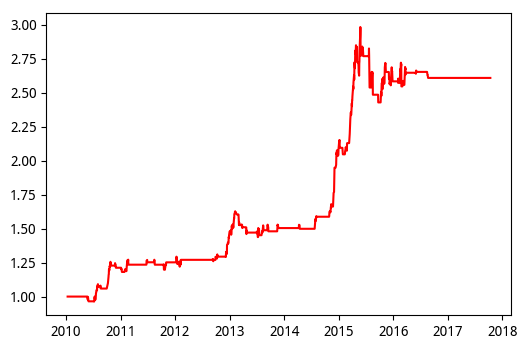

In [25]:
res['retl'] =  df.multiply(long)
plt.plot_date(Date,np.exp(res['retl'].cumsum()),'r-')

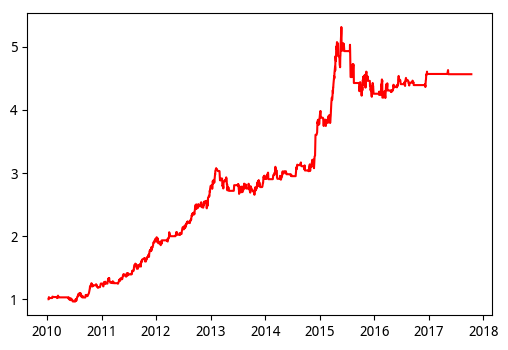

In [26]:
res['rets'] =  df.multiply(short)
plt.plot_date(Date,1/np.exp(res['rets'].cumsum())*np.exp(res['retl'].cumsum()),'r-')

## 可以看到效果还是很不错的。但事实上该结果是有些问题的。真实操作时，我们并没有未来的信息来训练模型。不过可以考虑用历史数据进行训练，再对之后的数据进行预测。